# Lecture : Introduction to Graph Science

## Lab 03 : Graph construction with pre-processing -- Exercise

### Xavier Bresson, Nian Liu 


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/02_Graph_Science'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Load libraries
import numpy as np
%matplotlib inline
#%matplotlib notebook 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.sparse # sparse matrix
import scipy.sparse.linalg
from matplotlib import pyplot
import scipy.io # import data
import sys; sys.path.insert(0, 'lib/')
%load_ext autoreload
%autoreload 2
from lib.utils import compute_ncut
import sklearn.metrics.pairwise # distance function
import warnings; warnings.filterwarnings("ignore")


(2000, 100) (2000,)


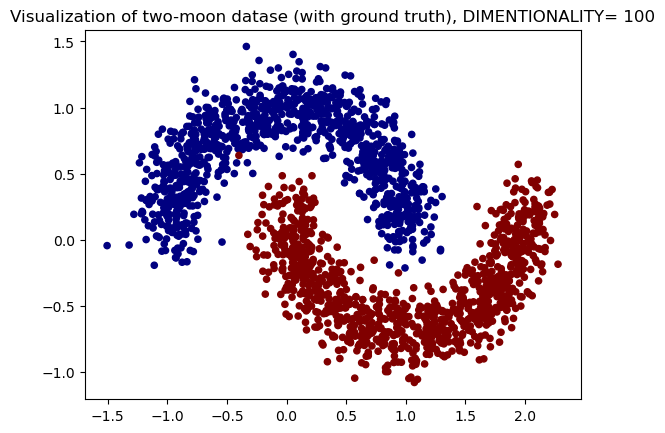

In [3]:
# Load two-moon datasets
mat = scipy.io.loadmat('datasets/two_moon_100D.mat'); dim = 100
#mat = scipy.io.loadmat('datasets/two_moon_2D.mat'); dim = 2
X = mat['X']
n = X.shape[0]; C = np.zeros([n]); C[-int(n/2):] = 1
print(X.shape,C.shape)

# Visualize in 2D
plt.figure(1)
size_vertex_plot = 20.
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C, color=pyplot.jet())
plt.title('Visualization of two-moon datase (with ground truth), DIMENTIONALITY= ' + str(dim))
plt.show()


### Question 1 : Center the dataset X and plot the result

Given a dataset $X\in\mathbb{R}^{n\times d}$, centering it to have zero mean involves subtracting the mean of the dataset from each data point: 

$x_i \ \leftarrow x_i - \textrm{mean}(\{x_i\}_{i=1}^n)\in\mathbb{R}^d$


(2000, 100)


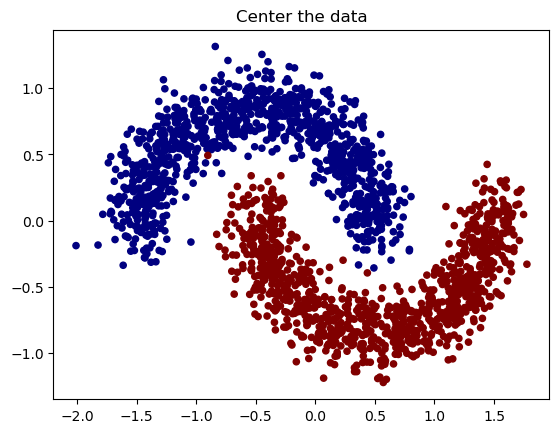

In [4]:
# size(X) = nb_data x dim
# YOUR CODE HERE <- Need to specify axis. X[i : j]
Xzc = X - np.mean(X, axis=0)
print(Xzc.shape)

plt.figure(2)
# YOUR CODE HERE 
plt.scatter(Xzc[:,0], Xzc[:,1], s=size_vertex_plot*np.ones(n), c=C, color=pyplot.jet())
plt.title('Center the data')
plt.show()


### Question 2 : Normalize the variance of the dataset X and plot the result

To normalize the variance of the dataset $X\in\mathbb{R}^{n\times d}$, divide each data point by the standard deviation of the dataset:

$x_i \ \leftarrow x_i / \textrm{std}(\{x_i\}_{i=1}^n)\in\mathbb{R}^d$


(2000, 100)


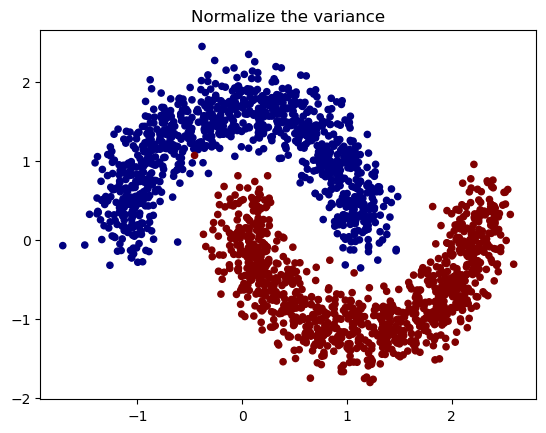

In [5]:
# size(X) = nb_data x dim
# YOUR CODE HERE 
Xnvar = X / np.std(X, axis=0)
print(Xnvar.shape)

plt.figure(3)
# YOUR CODE HERE 
plt.scatter(Xnvar[:,0], Xnvar[:,1], s=size_vertex_plot*np.ones(n), c=C, color=pyplot.jet())
plt.title('Normalize the variance')
plt.show()


### Question 3 : Project the dataset X onto a unit sphere and plot the result

To project a dataset $X\in\mathbb{R}^{n\times d}$ onto a unit sphere, normalize each data point by its Euclidean norm:

$x_i \ \leftarrow x_i /||x_i||_2 \in\mathbb{R}^d$


(2000, 100)


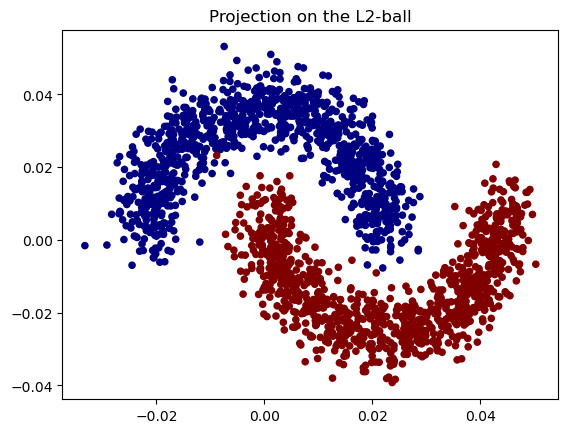

In [6]:
# size(X) = nb_data x dim
# YOUR CODE HERE 
Xl2proj = X / np.linalg.norm(X, axis=0, ord=2)
print(Xl2proj.shape)

plt.figure(4)
# YOUR CODE HERE 
plt.scatter(Xl2proj[:,0], Xl2proj[:,1], s=size_vertex_plot*np.ones(n), c=C, color=pyplot.jet())
plt.title('Projection on the L2-ball')
plt.show()


### Question 4 : Construct a k-NN graph using L2/Euclidean distance

1. **Center the Dataset:** Begin by centering the dataset X to have a mean of zero.
   
2. **Compute Pairwise Distances:** Calculate the pairwise Euclidean distances D between all data points. You can use the `pairwise_distances()` function from the `sklearn` library: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html.

3. **Sort Distance Matrix:** Organize the distance matrix D in ascending order, from the smallest to the largest distances.

4. **Extract k-NN:** Identify the k-nearest neighbors for each data point based on the sorted distance matrix.

5. **Compute Adjacency Matrix:** Create the adjacency matrix W using Gaussian weights. This involves applying the Gaussian function to the distances.

6. **Make Adjacency Matrix Sparse:** Convert the adjacency matrix W into a sparse matrix to optimize storage and computation.

7. **Symmetrize Matrix:** Ensure the adjacency matrix W is symmetric by averaging W with its transpose.


In [7]:
######################################
# Construct a k-NN graph with L2/Euclidean distance
######################################

# Compute L2/Euclidean distance between all pairs of points
# Step 1: Center the Dataset
Xzc = X - np.mean(X,axis=0) # zero-centered data 
# Step 2: Compute Pairwise Distances
D = sklearn.metrics.pairwise.pairwise_distances(Xzc, metric='euclidean')# YOUR CODE HERE # Default metric is Euclidean
print(D.shape)

# Step 3: Sort distance matrix
k = 10 # number of nearest neighbors
idx = np.argsort(D)[:,:k] # indices of k nearest neighbors
Dnot_sorted = np.copy(D)
D.sort() # sort D from smallest to largest values
Dsorted = np.copy(D)
print(D.shape)
D = D[:,:k]
print(D.shape)

# Compute weight matrix
sigma2 = np.mean(D[:,-1])**2 # graph scale
W = np.exp(- D**2 / sigma2)
#print(W.shape)

# Make W sparse
n = X.shape[0]
row = np.arange(0, n).repeat(k)
col = idx.reshape(n*k)
data = W.reshape(n*k)
W = scipy.sparse.csr_matrix((data, (row, col)), shape=(n, n))

# Make W is symmetric
bigger = W.T > W
W = W - W.multiply(bigger) + W.T.multiply(bigger)

# No self-connections
#W.setdiag(0)

print(W.shape)
print(W.nnz)


(2000, 2000)
(2000, 2000)
(2000, 10)
(2000, 2000)
31388


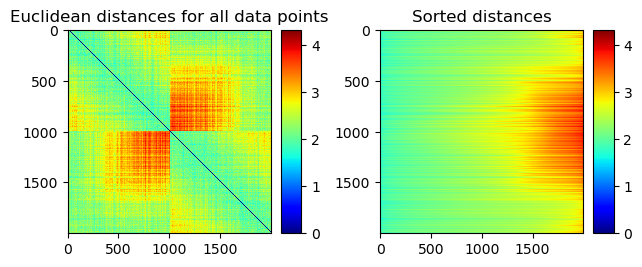

In [8]:
# Visualize distances
fig, (ax1, ax2) = plt.subplots(1,2)
#fig.suptitle('Title of figure 2', fontsize=15)

ax1.set_title('Euclidean distances for all data points')
im1 = ax1.imshow(Dnot_sorted, interpolation='nearest')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.1)
ax1.get_figure().colorbar(im1, cax=cax1)

ax2.set_title('Sorted distances')
im2 = ax2.imshow(Dsorted, interpolation='nearest')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="10%", pad=0.1)
ax2.get_figure().colorbar(im2, cax=cax2)

fig.tight_layout()

fig.show()


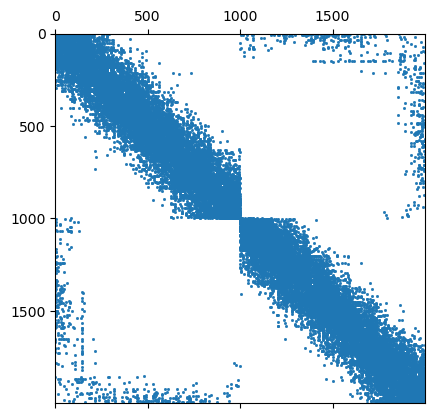

In [9]:
plt.figure(5)
plt.spy(W,precision=0.01, markersize=1, color=pyplot.jet())
plt.show()


### Comment

To assess the quality of the constructed adjacency matrix, one effective approach is to compute the classification error relative to some ground truth communities.

In this notebook, we evaluate the adjacency matrix by comparing the ground truth communities C with the communities estimated using the NCut graph partitioning algorithm: http://www.cis.upenn.edu/~jshi/software.


In [10]:
Cncut, acc = compute_ncut(W, C, 2)
print(acc)


93.85


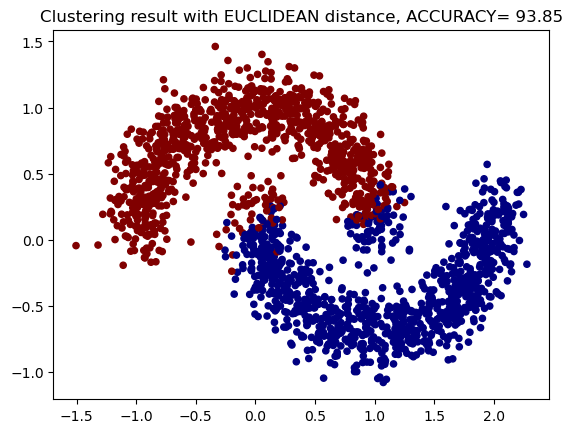

In [11]:
plt.figure(6)
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cncut, color=pyplot.jet())
plt.title('Clustering result with EUCLIDEAN distance, ACCURACY= '+ str(acc))
plt.show()


### Question 5 : Construct a k-NN graph using cosine distance

1. **Construct k-NN Graph:** Build a k-NN graph using cosine distance as the metric. The cosine distance may be computed using the `arccos()` function from NumPy: https://numpy.org/doc/stable/reference/generated/numpy.arccos.html.

2. **Evaluate Quality:** Assess the quality of the adjacency matrix construction by comparing it with the ground truth communities. Use the NCut graph partitioning algorithm to estimate communities and evaluate the performance.



In [12]:
######################################
# Construct k-NN graph with Cosine distance
######################################

# Compute Cosine distance between all pairs of points
Xzc = X - np.mean(X,axis=0) # zero-centered data
Xl2proj = ( Xzc.T / np.sqrt(np.sum(Xzc**2,axis=1)+1e-10) ).T # Projection on the sphere, i.e. ||x_i||_2 = 1
D = Xl2proj.dot(Xl2proj.T)
#print(D.shape)

# Sort D according in descending order
k = 10 # number of nearest neighbors
idx = np.argsort(D)[:,::-1][:,:k] # indices of k nearest neighbors
Dnot_sorted = np.copy(D)
D.sort(axis=1)
D[:] = D[:,::-1]
Dsorted = np.copy(D)

# Cosine distance
Dcos = np.abs(np.arccos(D))# YOUR CODE HERE 
D = Dcos
D = D[:,:k]
print(D.shape)

# Compute Weight matrix
sigma2 = np.mean(D[:,-1])**2 # graph scale
W = np.exp(- D**2 / sigma2)
#print(W.shape)

# Make W sparse
n = X.shape[0]
row = np.arange(0, n).repeat(k)
col = idx.reshape(n*k)
data = W.reshape(n*k)
W = scipy.sparse.csr_matrix((data, (row, col)), shape=(n, n))

# Make W is symmetric
bigger = W.T > W
W = W - W.multiply(bigger) + W.T.multiply(bigger)

# No self-connections
#W.setdiag(0)

print(W.shape)
print(W.nnz)


(2000, 10)
(2000, 2000)
32914


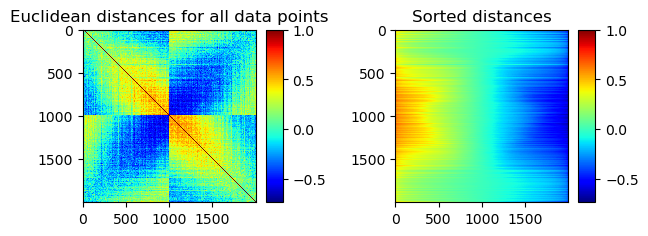

In [13]:
# Visualize distances
fig, (ax1, ax2) = plt.subplots(1,2)
#fig.suptitle('Title of figure 2', fontsize=15)

ax1.set_title('Euclidean distances for all data points')
im1 = ax1.imshow(Dnot_sorted, interpolation='nearest')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.1)
ax1.get_figure().colorbar(im1, cax=cax1)

ax2.set_title('Sorted distances')
im2 = ax2.imshow(Dsorted, interpolation='nearest')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="10%", pad=0.1)
ax2.get_figure().colorbar(im2, cax=cax2)

fig.tight_layout()

fig.show()


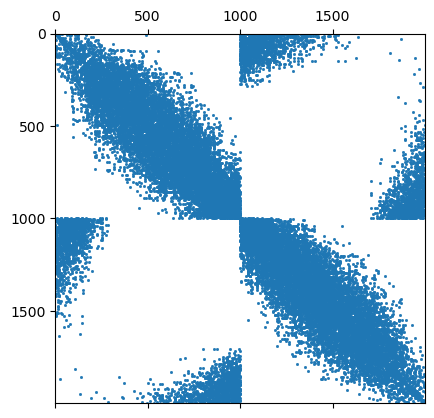

In [14]:
plt.figure(7)
plt.spy(W,precision=0.01, markersize=1, color=pyplot.jet())
plt.show()


In [15]:
Cncut, acc = compute_ncut(W, C, 2)
print(acc)


80.35


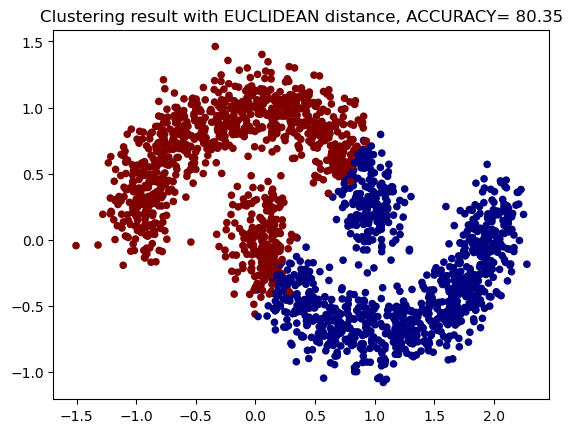

In [16]:
plt.figure(8)
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cncut, color=pyplot.jet())
plt.title('Clustering result with EUCLIDEAN distance, ACCURACY= '+ str(acc))
plt.show()
